In [57]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import loguniform
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import neural_network
import seaborn as sns
import matplotlib.cm as cm
from sklearn.model_selection import validation_curve
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout 
# from tensorflow.keras.layers import BatchNormalization 
# from tensorflow.keras.callbacks import ModelCheckpoint # new!
import os # new!
# import seaborn as sns
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout 
# from tensorflow.keras.layers import BatchNormalization 
# from tensorflow.keras.callbacks import ModelCheckpoint # new!


In [58]:
batch_size = 5
box_plot_title = 'Memory Estimation Error (MB)'
pd.set_option('display.max_columns', None)
# cluster_set = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

# 1. Loading training and test datasets

In [59]:
def load_data():
    df = pd.read_csv('job2_scaled_clean.csv')
    # df_test = pd.read_csv('job2_test_clean.csv')
    return df

In [60]:
df = load_data()

# 2. Train and Evaluate a Model

In [61]:
def batch_predict(estimator, batch_size, X, Y):
    predicted = estimator.predict(X)
    Y = np.insert(Y, Y.shape[1], predicted, axis=1)
    
    indices = np.linspace(0, X.shape[0]-1, X.shape[0], dtype=int)
    np.random.seed(42)
    np.random.shuffle(indices)
    num_batches = int(np.floor(X.shape[0] / batch_size))
    
    df_batches = pd.DataFrame(columns=['actual', 'db2', 'ml'])
    
    for ibat in range(num_batches):
        start = (ibat * batch_size)
        end = (ibat * batch_size + batch_size) - 1
        
        ibat_Y = Y[indices[start:end]]
        
        actual = sum(ibat_Y[:,-1])
        db2 = sum(ibat_Y[:,-2])
        ml = sum(ibat_Y[:,-3])
        
        df_batches = df_batches.append({'actual':actual,
                                       'db2':db2,
                                       'ml':ml},
                                      ignore_index=True)
        
    return df_batches

def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict
    
def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y, length, height):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[length,height])
    plt.rcParams.update({'font.size': 16})
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=22)
    plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    ax.xaxis.set_ticks_position('both')
    #ax.set_yticks(yticks_new)
#     plt.setp(ax.get_yticklabels(), rotation=90)
    f.tight_layout()
    plt.show()
    ax.savefig('job_err.png')
def residual_plot(Y):
    Y_predicted = Y.iloc[:,1:]
    print('Y_predicted ', Y_predicted.shape)
    cols = Y_predicted.columns
    markers = ['8', 'P', '*', 'h', 'X','+','^','s','o']
#     colors = ['steelblue', 'darkorange', 'darkorchid', 'limegreen', 'fuchsia']
    colors = cm.rainbow(np.linspace(0, 1, len(cols)))
    
    Y_residuals = calculate_residuals(Y)
    print('Y_residuals ', Y_residuals.shape)
    
    for col in cols:
        plot_index = Y_predicted.columns.get_loc(col)
        plt.scatter(Y_predicted[col], Y_residuals[col], 
                   edgecolor='white', c=colors[plot_index],
                   marker=markers[plot_index], label=col)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=0, xmax=9000, color='black', lw=2)
    plt.xlim([0, 9000])
    plt.tight_layout()
    plt.show()

# Clustering 

In [62]:
def get_clusters(k, data, km):
    X = data.drop(columns=['db2', 'actual'])
    
    if km is not None:
        print('clustering test dataset')
        y_kmeans = km.predict(X)
    else:
        print('clustering train dataset')
        km = KMeans(
            n_clusters=k, 
            init='k-means++', 
            n_init=10, 
            max_iter=300, 
            random_state=0
        )
        km.fit(X)
        y_kmeans = km.predict(X)

    print('Distortion: %.2f' % km.inertia_)
    
    df = data.copy()
    df['cluster'] = y_kmeans  # Directly assign the entire array (more efficient)
    df['cluster'] = df['cluster'].astype('int64')
    
    return df

# Workload

In [63]:
import pandas as pd
import numpy as np

def create_workload(batch_size, data):
    # Select relevant columns
    df_data = data[['db2', 'actual', 'cluster']]
    
    labels = df_data['cluster'].unique()
    labels = np.sort(labels)
    cluster_columns = [f"cluster_{int(c)}" for c in labels]
    
    # If df_data came from a filter like df_clusters_pruned[df_clusters_pruned["…"]]
    df_data = df_data.copy()                    # break the view‑link

    df_data.loc[:, "cluster"] = df_data["cluster"].astype("int64")  # safe
    df_data = pd.get_dummies(df_data, columns=["cluster"], dtype=int)

    # # cluster_columns = [f'cluster_{i}.0' for i in range(k)]
    
    missing_columns = [col for col in cluster_columns if col not in df_data.columns]
    if missing_columns:
        # Create a DataFrame with missing columns set to 0
        df_missing = pd.DataFrame(0, index=df_data.index, columns=missing_columns)
        # Concatenate the missing columns
        df_data = pd.concat([df_data, df_missing], axis=1)

    # Sort columns to maintain a consistent order (optional)
    df_data = df_data.reindex(columns=['db2', 'actual'] + cluster_columns)
    
    # Initialize batches
    df_batches = []
    indices = np.arange(len(df_data))
    num_batches = len(df_data) // batch_size
    
    # Create batches
    for ibat in range(num_batches):
        batch_indices = indices[ibat * batch_size:(ibat + 1) * batch_size]
        ibat_Y = df_data.iloc[batch_indices]
        df_batches.append(ibat_Y.sum())

    # Combine batches into a DataFrame
    return pd.DataFrame(df_batches)


In [64]:
k = 50
df_clusters = get_clusters(k, df, None)

clustering train dataset
Distortion: 0.01


In [65]:
df_clusters.shape

(2332, 9)

In [66]:
df_clusters.head()

,TQ,TQ COUNT,TBSCAN,TBSCAN COUNT,HS JOIN,HS JOIN COUNT,db2,actual,cluster
0,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,521.280,251.296,23
1,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.296,251.296,23
2,0.081201,0.0,1.021729,0.832788,-0.055947,0.832788,251.264,251.248,31
3,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.248,251.252,23
4,-0.165491,0.0,0.623686,0.832788,-0.053342,0.832788,171.500,171.316,9


In [67]:
df_clusters["cluster"].nunique()

50

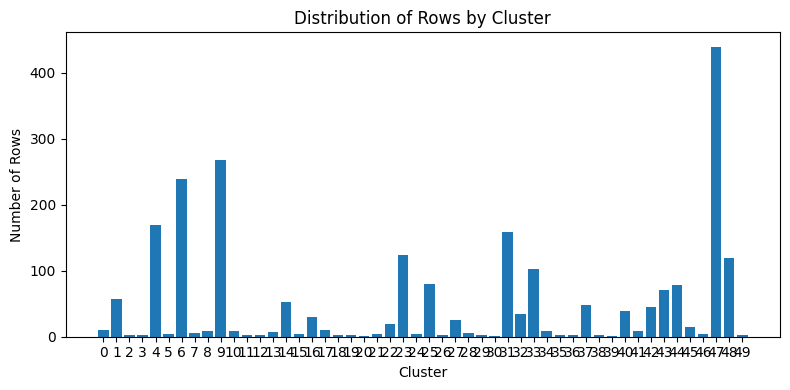

In [68]:
import matplotlib.pyplot as plt

# Count the number of rows in each cluster
cluster_counts = df_clusters["cluster"].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(cluster_counts.index, cluster_counts.values)

# Add labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Rows")
plt.title("Distribution of Rows by Cluster")
plt.xticks(cluster_counts.index)

# Show the plot
plt.tight_layout()
plt.show()

# Prune templates with 10 or fewer queries

In [69]:
import pandas as pd

# 1️⃣  Choose a threshold --------------------------------------------------
min_rows = 10                     # keep clusters that have ≥ 50 rows
# -- or, keep clusters that represent at least 1 % of the data —
# min_rows = int(0.01 * len(df_clusters))

# 2️⃣  Identify the clusters to keep --------------------------------------
cluster_counts = df_clusters["cluster"].value_counts()      # rows per cluster
keep_clusters  = cluster_counts[cluster_counts >= min_rows].index

# 3️⃣  Create the pruned DataFrame ----------------------------------------
df_clusters_pruned = df_clusters[df_clusters["cluster"].isin(keep_clusters)].copy()

# (optional) reset row index
df_clusters_pruned.reset_index(drop=True, inplace=True)

# (optional) re‑label clusters so they’re 0, 1, 2, … again
# mapping = {old:i for i, old in enumerate(sorted(keep_clusters))}
# df_clusters_pruned["cluster"] = df_clusters_pruned["cluster"].map(mapping)

print(f"Kept {len(keep_clusters)} clusters, "
      f"{len(df_clusters_pruned)} of {len(df_clusters)} total rows.")

Kept 23 clusters, 2229 of 2332 total rows.


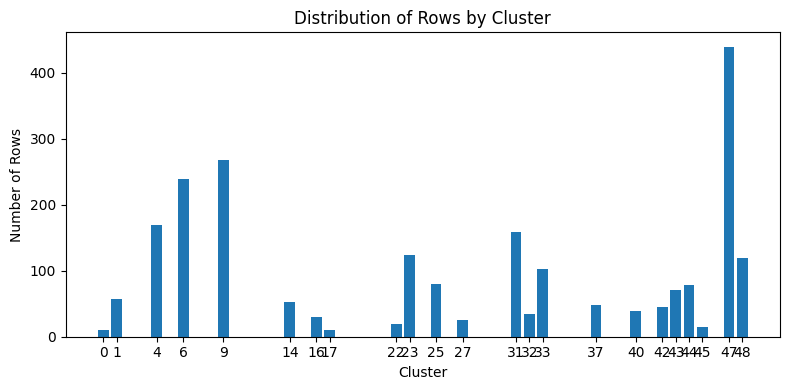

In [70]:
import matplotlib.pyplot as plt

# Count the number of rows in each cluster
cluster_counts = df_clusters_pruned["cluster"].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 4))
plt.bar(cluster_counts.index, cluster_counts.values)

# Add labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Rows")
plt.title("Distribution of Rows by Cluster")
plt.xticks(cluster_counts.index)

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
df_clusters_pruned["cluster"].nunique()

23

In [72]:
from typing import List, Tuple
import numpy as np
import pandas as pd

def row_balanced_cluster_kfolds(
    df: pd.DataFrame,
    cluster_col: str = "cluster",
    n_splits: int = 5,
    seed: int | None = 42
) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Perform row-balanced k-fold CV such that clusters are non-overlapping across folds
    and each fold has roughly equal number of rows (not necessarily clusters).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with a cluster identifier column.
    cluster_col : str, default "cluster"
        Column name that contains cluster identifiers.
    n_splits : int, default 5
        Number of folds for cross-validation.
    seed : int or None, default 42
        Seed for reproducibility.

    Returns
    -------
    folds : List of (train_df, val_df) tuples
    """
    # 1️⃣ Compute cluster sizes
    cluster_sizes = df.groupby(cluster_col).size().to_dict()
    unique_clusters = list(cluster_sizes.keys())

    # 2️⃣ Shuffle clusters
    rng = np.random.default_rng(seed)
    rng.shuffle(unique_clusters)

    # 3️⃣ Distribute clusters to balance row counts
    fold_clusters = [[] for _ in range(n_splits)]
    fold_sizes = [0] * n_splits

    for cluster in unique_clusters:
        size = cluster_sizes[cluster]
        min_fold = np.argmin(fold_sizes)
        fold_clusters[min_fold].append(cluster)
        fold_sizes[min_fold] += size

    # 4️⃣ Create folds: (train_df, val_df)
    folds = []
    for i in range(n_splits):
        val_clusters = fold_clusters[i]
        train_clusters = [c for j in range(n_splits) if j != i for c in fold_clusters[j]]

        df_train = df[df[cluster_col].isin(train_clusters)].copy()
        df_val = df[df[cluster_col].isin(val_clusters)].copy()

        folds.append((df_train, df_val))

    return folds


In [73]:
folds = row_balanced_cluster_kfolds(df_clusters_pruned, cluster_col='cluster', n_splits=5, seed=42)

i = 3  # Choose the fold index you want (0 to 4)

df_train, df_test = folds[i]

print(f"Using Fold {i + 1}")
print(f"Train rows: {len(df_train)}, Val rows: {len(df_test)}")
print(f"Train clusters: {df_train['cluster'].nunique()}, Val clusters: {df_test['cluster'].nunique()}")


Using Fold 4
Train rows: 1866, Val rows: 363
Train clusters: 17, Val clusters: 6


In [74]:
df_train.shape

(1866, 9)

In [75]:
df_test.shape

(363, 9)

In [76]:
df_train.head()

,TQ,TQ COUNT,TBSCAN,TBSCAN COUNT,HS JOIN,HS JOIN COUNT,db2,actual,cluster
0,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,521.280,251.296,23
1,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.296,251.296,23
2,0.081201,0.0,1.021729,0.832788,-0.055947,0.832788,251.264,251.248,31
3,0.053706,0.0,1.021729,0.832788,-0.055953,0.832788,251.248,251.252,23
4,-0.165491,0.0,0.623686,0.832788,-0.053342,0.832788,171.500,171.316,9


# Create Workloads

In [77]:
df_train.columns

Index(['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'HS JOIN', 'HS JOIN COUNT',
       'db2', 'actual', 'cluster'],
      dtype='object')

In [78]:
import os

# Ensure the folder exists
output_folder = "cluster_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
df_train_workloads = create_workload(batch_size, df_train)
df_test_workloads = create_workload(batch_size, df_test)

# for k in cluster_set:
#     km, df_clusters = get_clusters(k, df, None)
    
#     workload_train = create_workload(batch_size, df_train_clusters, k)
#     # workload_test = create_workload(batch_size, df_test_clusters, k)

#     file_name_train = os.path.join(output_folder, f'train_workloads_final_{k}_clusters.csv')
#     # file_name_test = os.path.join(output_folder, f'test_workloads_final_{k}_clusters.csv')
    
#     workload_train.to_csv(file_name_train, index=False)
#     # workload_test.to_csv(file_name_test, index=False)
    
#     print(f"k = {k} is done")

In [79]:
df_train_workloads.shape

(373, 19)

In [80]:
df_train_workloads.head()

,db2,actual,cluster_0,cluster_4,cluster_6,cluster_9,cluster_16,cluster_17,cluster_23,cluster_25,cluster_27,cluster_31,cluster_32,cluster_37,cluster_40,cluster_42,cluster_43,cluster_44,cluster_47
0,1446.588,1176.408,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1096.744,1095.676,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,1256.256,1256.344,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,857.500,820.872,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,857.500,822.888,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
df_train_workloads.columns

Index(['db2', 'actual', 'cluster_0', 'cluster_4', 'cluster_6', 'cluster_9',
       'cluster_16', 'cluster_17', 'cluster_23', 'cluster_25', 'cluster_27',
       'cluster_31', 'cluster_32', 'cluster_37', 'cluster_40', 'cluster_42',
       'cluster_43', 'cluster_44', 'cluster_47'],
      dtype='object')

In [82]:
df_test_workloads.head()

,db2,actual,cluster_1,cluster_14,cluster_22,cluster_33,cluster_45,cluster_48
0,1096.744,1082.904,0.0,2.0,0.0,3.0,0.0,0.0
1,857.500,860.220,0.0,5.0,0.0,0.0,0.0,0.0
2,937.248,941.672,0.0,0.0,0.0,1.0,0.0,4.0
3,1096.744,1099.452,0.0,2.0,0.0,3.0,0.0,0.0
4,937.248,932.888,0.0,2.0,0.0,1.0,0.0,2.0


In [83]:
df_test_workloads.columns

Index(['db2', 'actual', 'cluster_1', 'cluster_14', 'cluster_22', 'cluster_33',
       'cluster_45', 'cluster_48'],
      dtype='object')

In [84]:
df_test_workloads.shape

(72, 8)

align the two frames on their columns and tell pandas to fill anything that’s missing with 0

In [85]:
# ---- 1️⃣  Align the two frames on their columns (outer join) -------------
df_train_workloads, df_test_workloads = (
    df_train_workloads.align(
        df_test_workloads,
        join="outer",      # union of columns
        axis=1,            # align on columns
        fill_value=0       # 0 for every newly created cell
    )
)

# ---- 2️⃣  Move 'db2' and 'actual' to the front ---------------------------
def move_metrics_first(df: pd.DataFrame) -> pd.DataFrame:
    front = ["db2", "actual"]
    rest  = [c for c in df.columns if c not in front]
    return df[front + rest]

df_train_workloads = move_metrics_first(df_train_workloads)
df_test_workloads  = move_metrics_first(df_test_workloads)

# ---- 3️⃣  (Optional) cast the dummy columns back to int ------------------
for df in (df_train_workloads, df_test_workloads):
    dummy_cols = [c for c in df.columns if c.startswith("cluster_")]
    df[dummy_cols] = df[dummy_cols].astype(np.int8)   # or int64 / Int8

In [86]:
df_train_workloads.columns

Index(['db2', 'actual', 'cluster_0', 'cluster_1', 'cluster_14', 'cluster_16',
       'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27',
       'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4',
       'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45',
       'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9'],
      dtype='object')

In [87]:
df_test_workloads.columns

Index(['db2', 'actual', 'cluster_0', 'cluster_1', 'cluster_14', 'cluster_16',
       'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27',
       'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4',
       'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45',
       'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9'],
      dtype='object')

In [88]:
df_train_workloads.head()

,db2,actual,cluster_0,cluster_1,cluster_14,cluster_16,cluster_17,cluster_22,cluster_23,cluster_25,cluster_27,cluster_31,cluster_32,cluster_33,cluster_37,cluster_4,cluster_40,cluster_42,cluster_43,cluster_44,cluster_45,cluster_47,cluster_48,cluster_6,cluster_9
0,1446.588,1176.408,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1096.744,1095.676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2
2,1256.256,1256.344,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0
3,857.500,820.872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,857.500,822.888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


Validate that each row in both dataframes has exactly 5 queries

In [89]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------------------------
# Adjust once here if your batch size ever changes.
BATCH_SIZE = 5
# ---------------------------------------------------------------------------

def validate_cluster_counts(df: pd.DataFrame, batch_size: int = BATCH_SIZE):
    """
    Ensure the dummy cluster columns in *df* sum to *batch_size* in every row.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns named 'cluster_*'.
    batch_size : int, default 5
        The expected row‑sum across cluster_* columns.

    Returns
    -------
    pd.DataFrame
        A view of any rows that violate the rule (empty → everything is OK).
    """
    cluster_cols = [c for c in df.columns if c.startswith("cluster_")]
    if not cluster_cols:
        raise ValueError("No columns named 'cluster_*' found")

    wrong_rows = df[np.abs(df[cluster_cols].sum(axis=1) - batch_size) > 0]
    return wrong_rows


# --- Example usage ---------------------------------------------------------
bad_train = validate_cluster_counts(df_train_workloads)  # rows whose sum ≠ 5
bad_test  = validate_cluster_counts(df_test_workloads)

if bad_train.empty and bad_test.empty:
    print("✅ Every row sums to 5 — both DataFrames are consistent.")
else:
    print(f"🚩 Train rows off‑total:\n{bad_train.index.tolist()}")
    print(f"🚩 Test  rows off‑total:\n{bad_test.index.tolist()}")


✅ Every row sums to 5 — both DataFrames are consistent.


In [90]:
df_train_workloads.columns

Index(['db2', 'actual', 'cluster_0', 'cluster_1', 'cluster_14', 'cluster_16',
       'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27',
       'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4',
       'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45',
       'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9'],
      dtype='object')

In [91]:
df_train_workloads.head()

,db2,actual,cluster_0,cluster_1,cluster_14,cluster_16,cluster_17,cluster_22,cluster_23,cluster_25,cluster_27,cluster_31,cluster_32,cluster_33,cluster_37,cluster_4,cluster_40,cluster_42,cluster_43,cluster_44,cluster_45,cluster_47,cluster_48,cluster_6,cluster_9
0,1446.588,1176.408,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1096.744,1095.676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2
2,1256.256,1256.344,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0
3,857.500,820.872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
4,857.500,822.888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [92]:

def load_train_data():
    df = df_train_workloads
    
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]    
    print(feature_cols)

    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col].values.ravel()  # Flatten y to 1D
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y


def load_test_data():
    df = df_test_workloads
  
    # Assuming `df` is your DataFrame
    feature_cols = [col for col in df.columns if col.startswith('cluster_')]
    print(feature_cols)
    
    target_cols = ['db2', 'actual']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X, Y

def my_validation_curve(estimator_name, estimator, param_name, param_range):
    train_scores, valid_scores = validation_curve(estimator, X, y, param_name=param_name,
        param_range=param_range, cv=10, scoring="neg_mean_squared_error",
    )

    train_scores = np.sqrt(np.abs(train_scores))
    valid_scores = np.sqrt(np.abs(valid_scores))
    
    print(len(train_scores))
    print(len(valid_scores))

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    title_str = "Validation Curve with " + estimator_name
    plt.title(title_str)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.plot(param_range, train_scores_mean, label="train rmse")
    plt.plot(param_range, valid_scores_mean, label="validation rmse")

    plt.legend(loc='lower right')
    plt.show()
    
    train_rmse = [round(elem, 2) for elem in train_scores_mean]
    valid_rmse = [round(elem, 2) for elem in valid_scores_mean]
    
    df_scores = pd.DataFrame({'param': param_range, 'train_rmse': train_rmse, 'valid_rmse': valid_rmse})
    print(df_scores)
    
from sklearn.metrics import mean_squared_error
import numpy as np

def cross_validate(model):
    # Load data
    X, y = load_train_data()
    train_data = X.copy()
    train_targets = y.copy()

    k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    train_rmse = np.sqrt(np.mean(all_train_scores))
    val_rmse = np.sqrt(np.mean(all_scores))

    print('train rmse:', train_rmse)
    print('validation rmse:', val_rmse)

    return train_rmse, val_rmse

In [93]:
X, y = load_train_data()

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)


In [94]:
rmse_scores = {}

# Ridge Cross-Validate

In [95]:
ridge = Ridge(
        fit_intercept=True, 
        solver='lsqr',
        alpha = 1.0,
        random_state=42)

rmse_scores['Ridge'] = cross_validate(ridge)
# ridge.fit(X, y)

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse: 29.67052942518619
validation rmse: 32.81462622755287


# Decision Tree Regression - Tuning max_features

In [96]:
tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=0.23,
    random_state=33,
)

rmse_scores['Decision Tree'] = cross_validate(tree)

tree.fit(X, y)

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse: 149.71022678579456
validation rmse: 163.5525955736291


DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.23, min_samples_split=4,
                      random_state=33)

# Forest final model - using tuned HP from AutoAI

In [97]:
forest = RandomForestRegressor(
    max_depth=5,
    max_features=0.6109469920813564,
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=17,
    #n_jobs=CPU_NUMBER,
    random_state=33,
)

rmse_scores['Random Forest'] = cross_validate(forest)

forest.fit(X, y)

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)
Processing fold #0
Processing fold #1
Processing fold #2


Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse: 67.62996780975342
validation rmse: 83.98486200371913


RandomForestRegressor(max_depth=5, max_features=0.6109469920813564,
                      min_samples_leaf=4, min_samples_split=5, n_estimators=17,
                      random_state=33)

# XGB Regressor

In [98]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(
    # --- general ----------------------------------------------------------
    objective="reg:squarederror",        # default for regression
    base_score=0.5,
    booster="gbtree",
    random_state=33,                     # controls all randomness
    seed=33,                             # still accepted (alias for random_state)

    # --- tree construction ------------------------------------------------
    tree_method="hist",                  # faster than "exact" on most CPUs
    device="cpu",                        # set to "cuda" for GPU training ➊
    n_jobs=1,                            # threads (was `nthread`) ➋
    n_estimators=879,
    learning_rate=0.1814227666290778,
    max_depth=1,
    min_child_weight=2,
    max_delta_step=0,

    # --- column / row sampling -------------------------------------------
    subsample=0.04694370939809412,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,

    # --- regularisation ---------------------------------------------------
    gamma=0.0,                           # alias for `min_split_loss`
    reg_alpha=1.0,
    reg_lambda=0.40529327440922186,

    # --- misc -------------------------------------------------------------
    interaction_constraints="",
    monotone_constraints="()",
    num_parallel_tree=1,
    scale_pos_weight=1,
    verbosity=0,                         # replaces deprecated `silent` ➌
    validate_parameters=True,            # still supported ➍
)


rmse_scores['XGBoost'] = cross_validate(xgb_regressor)

xgb_regressor.fit(X, y)

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)
Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse: 43.37217096439873
validation rmse: 53.81237191844856


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints='', learning_rate=0.1814227666290778,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=1, max_leaves=None, min_child_weight=2,
             missing=nan, monotone_constraints='()', multi_strategy=None,
             n_estimators=879, n_jobs=1, num_parallel_tree=1, ...)

# Deep Neural Network (DNN)

In [99]:
from sklearn.neural_network import MLPRegressor

dnn_model = dnn_model = MLPRegressor(max_iter=500,
                     alpha=0.001,
                     activation='identity',
                     learning_rate= 'constant',
                     random_state = 6,
                     hidden_layer_sizes = (48, 39, 27, 16, 7, 5),
                     solver = 'lbfgs'
                    )
rmse_scores['DNN'] = cross_validate(dnn_model)

dnn_model.fit(X, y)

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (373, 23)
y.shape:  (373,)
Processing fold #0


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse: 29.533671239583185
validation rmse: 32.635682907108496


MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=500,
             random_state=6, solver='lbfgs')

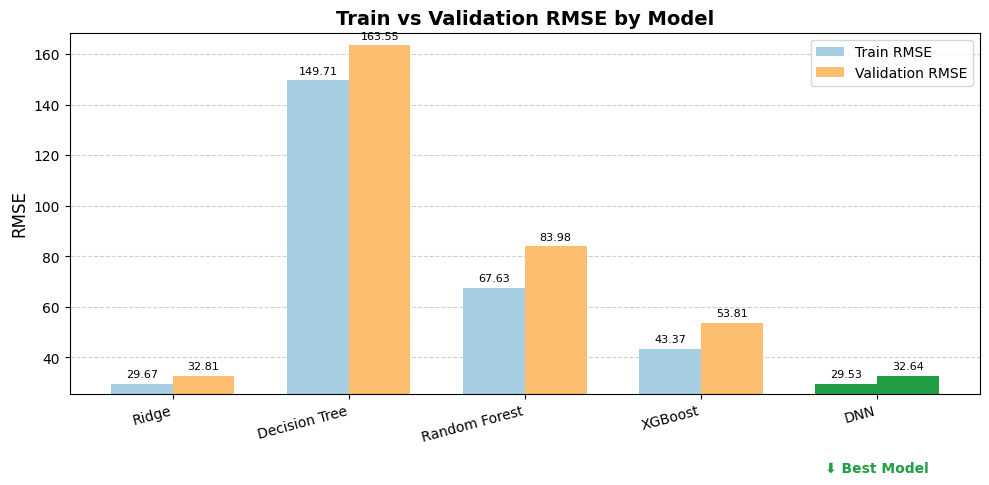

In [100]:
import matplotlib.pyplot as plt

# # Your RMSE results for each model
# rmse_scores = {
#     'DNN': (29.99, 33.11),
#     'XGBoost': (25.12, 26.80),
#     'Random Forest': (23.87, 25.43),
#     'Decision Tree': (24.55, 27.36),
#     'Ridge': (27.01, 29.42)
# }

# Extract model names and RMSE values
model_names = list(rmse_scores.keys())
train_rmses = [rmse_scores[model][0] for model in model_names]
val_rmses = [rmse_scores[model][1] for model in model_names]

# Identify the best model (lowest validation RMSE)
best_index = val_rmses.index(min(val_rmses))

# Plot setup
x = range(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

# Color settings
train_colors = ['#a6cee3' if i != best_index else '#1f9e44' for i in x]
val_colors = ['#fdbf6f' if i != best_index else '#1f9e44' for i in x]

# Draw bars
train_bars = ax.bar([i - width/2 for i in x], train_rmses, width, label='Train RMSE', color=train_colors)
val_bars = ax.bar([i + width/2 for i in x], val_rmses, width, label='Validation RMSE', color=val_colors)

# Add RMSE value labels on top of bars
for bar_group in [train_bars, val_bars]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Annotate "⬇ Best Model" below the best model label, slightly higher for spacing
ax.text(
    best_index,
    -1,  # Higher than before (-2)
    '⬇ Best Model',
    ha='center',
    va='top',
    fontsize=10,
    color='#1f9e44',
    fontweight='bold'
)

# Formatting and labels
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Train vs Validation RMSE by Model', fontsize=14, weight='bold')
ax.set_xticks(list(x))
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

# Adjust y-limits to make space for bottom label
ax.set_ylim(
    bottom=min(min(train_rmses), min(val_rmses)) - 4,
    top=max(max(train_rmses), max(val_rmses)) + 5
)

plt.tight_layout()
plt.show()


In [101]:
dnn_model.fit(X, y)

MLPRegressor(activation='identity', alpha=0.001,
             hidden_layer_sizes=(48, 39, 27, 16, 7, 5), max_iter=500,
             random_state=6, solver='lbfgs')

In [102]:
X_test, Y_test = load_test_data()

['cluster_0', 'cluster_1', 'cluster_14', 'cluster_16', 'cluster_17', 'cluster_22', 'cluster_23', 'cluster_25', 'cluster_27', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_37', 'cluster_4', 'cluster_40', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_47', 'cluster_48', 'cluster_6', 'cluster_9']
X.shape:  (72, 23)
y.shape:  (373,)


In [103]:
X_test.shape

(72, 23)

In [104]:
Y_test.shape

(72, 2)

In [105]:
Y_test = Y_test.copy()
Y_test.loc[:, 'dnn'] = dnn_model.predict(X_test.values)

In [106]:
# Ensure 'actual' is the first column
cols = ['actual'] + [col for col in Y_test.columns if col != 'actual']
Y_test = Y_test[cols]

In [107]:
Y_test.head()

,actual,db2,dnn
0,1082.904,1096.744,391.362251
1,860.220,857.500,339.477830
2,941.672,937.248,552.902439
3,1099.452,1096.744,391.362251
4,932.888,937.248,454.837538


In [108]:
rmse(Y_test)

{'db2': 565.0, 'dnn': 470.0}